## Imports

In [1]:
!pip install transformers torch torchvision Pillow
!pip install open_clip_torch
!pip install tqdm psutil scikit-learn matplotlib

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.4-cp313-cp313-win_amd64.whl.metadata (38 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.0 MB 2.8 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/12.0 MB 2.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/12.0 MB 2.1 MB/s eta 0:00:05
   ------ --------------------------------- 1.8/12.0 MB 1.1 MB/s eta 0:00:10
   ------ --------------------------------- 1.8/12.0 MB 1.1 MB/s eta 0:00:10
   ------ --------------------------------- 1.8/12.0 MB 1.1 MB/s eta 0:00:10
   ------ -------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------------- ------ 1.3/1.5 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------- ----------------------- 1.0/2.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.5 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 5.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
    --------------------------------------- 0.5/38.5 MB 393.5 kB/s eta 0:01:37
    --------------------------------------- 0.5/38.5 MB 393.5 kB/s eta 0:01:37
    --------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import time
import json
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm
import psutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import open_clip

c:\Users\louis\OneDrive\Documents\00 - Cours\FIE5\PTUT_CEVEOP\envCeveop\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# à modifier selon votre chemin

base_path = "Ressources/"

csv_physique = base_path + "inventaire_physique.csv"
csv_comptable = base_path + "inventaire_comptable.csv"
img_folder = base_path + "Images/"

## Préparation des données

1/ Inventaire physique réduit => columns : Img/Titre/codeEtiquette/NumInventaire

2/ Inventaire comptable => NumInventaire/des1/fournisseur

3/ lien entre les 2 (numInventaire) => correspondances réelles

In [5]:
df_physique = pd.read_csv(csv_physique)
df_comptable = pd.read_csv(csv_comptable,sep=";",encoding="latin-1")

C:\Users\louis\AppData\Local\Temp\ipykernel_924\3699852166.py:1: DtypeWarning: Columns (1,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_physique = pd.read_csv(csv_physique)


In [6]:
# Harmonisation du NumInventaire
df_physique = df_physique.rename(columns={"Num Inventaire": "NumInventaire"})
df_comptable = df_comptable.rename(columns={"numInventaire": "NumInventaire"})

# Supprime les lignes sans identifiant
df_physique = df_physique.dropna(subset=["NumInventaire"])
df_comptable = df_comptable.dropna(subset=["NumInventaire"])

In [7]:
# Création df commun
df_merged = pd.merge(
    df_physique,
    df_comptable,
    on="NumInventaire",
    how="inner"
)

print(len(df_merged), "correspondances trouvées dans le dataset")

6894 correspondances trouvées dans le dataset


In [8]:
# Création d’un texte descriptif pour chaque fiche comptable
df_merged["fiche_textuelle"] = (
    df_merged["des1"].fillna('') +
    ' ' + df_merged["des2"].fillna('') + ' '
    + df_merged["fournisseur"].fillna('')
).str.strip()

# Sélection des colonnes importantes
df_final = df_merged[[
    "Titre",
    "Img",
    "NumInventaire",
    "fiche_textuelle"
]]

df_final.head()

,Titre,Img,NumInventaire,fiche_textuelle
0,Chaise,b7c180e6-13d0-4365-afe7-c83a25746d8d.jpg,202000166,CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP
1,Chaise,c88762c5-3c03-4ad2-8a8a-b02add20dc4d.jpg,202000166,CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP
2,Chaise,63474d32-c1a6-44c1-b3f5-62bdcc2f8d24.jpg,9616256,CHAISE EMPILABLE 250 ASSISE ET DOSSIER BOIS CO...
3,Chaise,2ab1675c-8c43-4490-9c9d-23e86b1d3a50.jpg,9616256,CHAISE EMPILABLE 250 ASSISE ET DOSSIER BOIS CO...
4,Chaise pliante,6eb45daf-4706-49b9-af22-82b384e06fbc.jpg,202100185,CHAISE PLIANTE - LOT DE 4 REF. 2197403 - COULE...


In [9]:
df_test_sample = df_final.sample(n=50 , random_state=42).reset_index(drop=True)

## Initialisation du modèle

In [13]:
import torch
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model = model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/timm/vit_base_patch32_clip_224.openai/resolve/main/open_clip_model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
Trying to resume download...
c:\Users\louis\OneDrive\Documents\00 - Cours\FIE5\PTUT_CEVEOP\envCeveop\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\louis\.cache\huggingface\hub\models--timm--vit_base_patch32_clip_224.openai. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by sett

## Génération des embeddings

In [10]:
df_test_sample["Img_path"] = df_test_sample["Img"].apply(lambda x: img_folder + x)

In [14]:
def load_image(path):
    try:
        return Image.open(path).convert("RGB")
    except:
        print(f"⚠️ Impossible de charger {path}")
        return None

df_test_sample["image_obj"] = df_test_sample["Img_path"].apply(load_image)

In [15]:
# Supprimer les lignes dont l'image n'a pas été chargée
df_test_sample = df_test_sample.dropna(subset=["image_obj"]).reset_index(drop=True)

# Encodage des images
image_embeddings = []
for img in tqdm(df_test_sample["image_obj"], desc="Encodage images"):
    image_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(image_tensor)
        image_embeddings.append(emb.cpu())

image_embeddings = torch.cat(image_embeddings)

# Encodage des textes
text_tokens = tokenizer(df_test_sample["fiche_textuelle"].tolist()).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)
text_embeddings = text_embeddings.cpu()


Encodage images:   0%|          | 0/50 [00:00<?, ?it/s]

Encodage images: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


## Evaluation du modèle

In [16]:
import torch.nn.functional as F

image_embeddings = F.normalize(image_embeddings, dim=1)
text_embeddings = F.normalize(text_embeddings, dim=1)

similarity_matrix = image_embeddings @ text_embeddings.T


In [17]:
import numpy as np

num_samples = len(df_test_sample)
indices_correct = []

for i in range(num_samples):
    sims = similarity_matrix[i]
    ranking = torch.argsort(sims, descending=True)
    true_index = i  # correspondance via NumInventaire ou position
    indices_correct.append(ranking.tolist().index(true_index))

indices_correct = np.array(indices_correct)

top1 = np.mean(indices_correct == 0)
top5 = np.mean(indices_correct < 5)
mrr = np.mean(1 / (indices_correct + 1))


In [18]:
def precision_recall_f1_at_k(k):
    hits = (indices_correct < k).sum()
    precision = hits / (k * num_samples)
    recall = hits / num_samples
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

for k in [1, 5, 10]:
    p, r, f1 = precision_recall_f1_at_k(k)
    print(f"k={k} → Precision={p:.3f} | Recall={r:.3f} | F1={f1:.3f}")


k=1 → Precision=0.080 | Recall=0.080 | F1=0.080
k=5 → Precision=0.080 | Recall=0.400 | F1=0.133
k=10 → Precision=0.060 | Recall=0.600 | F1=0.109


In [19]:
import torch
import numpy as np

# similarity_matrix : (n_images x n_textes), déjà calculée
num_samples = similarity_matrix.shape[0]

# indices du vrai texte pour chaque image
# Si tes images et textes sont dans le même ordre, c'est juste la diagonale
true_indices = np.arange(num_samples)

top1_count = 0
top5_count = 0
top50_count = 0

for i in range(num_samples):
    sims = similarity_matrix[i]
    ranking = torch.argsort(sims, descending=True)  # indices triés du plus proche au plus éloigné
    true_idx = true_indices[i]

    if ranking[0].item() == true_idx:
        top1_count += 1
    if true_idx in ranking[:5].tolist():
        top5_count += 1
    if true_idx in ranking[:50].tolist():
        top50_count += 1

top1_accuracy = top1_count / num_samples
top5_accuracy = top5_count / num_samples
top50_accuracy = top50_count / num_samples

print(f"Top-1 Accuracy : {top1_accuracy:.3f}")
print(f"Top-5 Accuracy : {top5_accuracy:.3f}")
print(f"Top-50 Accuracy : {top50_accuracy:.3f}")

Top-1 Accuracy : 0.080
Top-5 Accuracy : 0.400
Top-50 Accuracy : 1.000


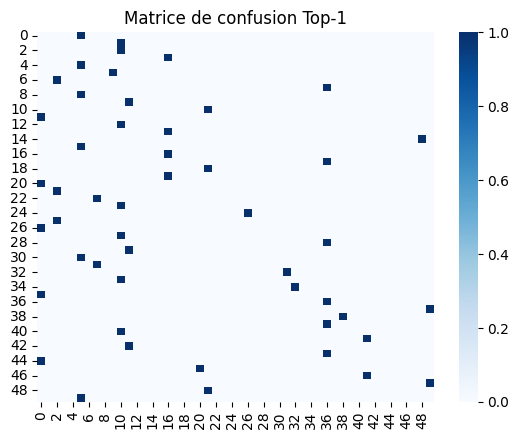

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = list(range(num_samples))
y_pred = [torch.argsort(similarity_matrix[i], descending=True)[0].item() for i in range(num_samples)]

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues")
plt.title("Matrice de confusion Top-1")
plt.show()


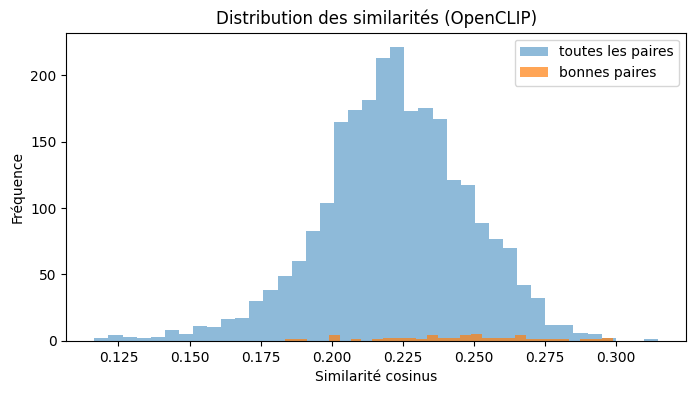

In [23]:
correct_sims = [similarity_matrix[i, i].item() for i in range(num_samples)]
all_sims = similarity_matrix.flatten().numpy()

plt.figure(figsize=(8,4))
plt.hist(all_sims, bins=40, alpha=0.5, label="toutes les paires")
plt.hist(correct_sims, bins=30, alpha=0.7, label="bonnes paires")
plt.legend()
plt.title("Distribution des similarités (OpenCLIP)")
plt.xlabel("Similarité cosinus")
plt.ylabel("Fréquence")
plt.show()


## Test

🎲 Exemples aléatoires :



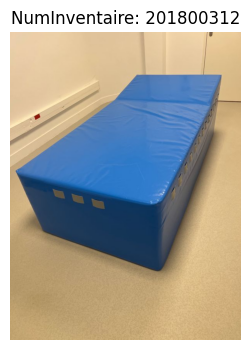

→ Fiche textuelle prédite :
 CHAISE PLIANTE TISSU ENDUIT BLEU ORAGE DIABOLO CLUB SIGNATURE SARL
→ Fiche textuelle correcte :
 BAT D-IFSI-SIMUL SANTE-F PLAFOND Devis 19-11-1347 du 25 11 2019 E P H
--------------------------------------------------------------------------------


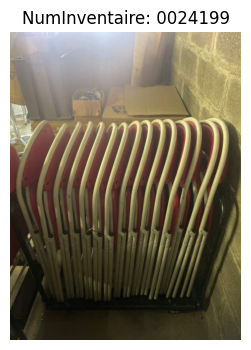

→ Fiche textuelle prédite :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
→ Fiche textuelle correcte :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
--------------------------------------------------------------------------------


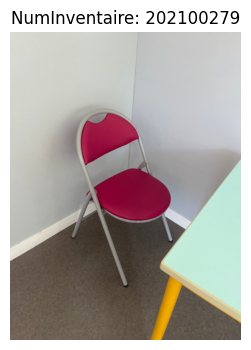

→ Fiche textuelle prédite :
 12 CHAISES PLIANTES URBA assise et dossier tissu enduit (6 citrouilles et SIGNATURE SARL
→ Fiche textuelle correcte :
 CHAISE PLIANTE FOLD - LOT DE 4 REF. 2197409 - FUCHSIA / GRIS ALU UGAP
--------------------------------------------------------------------------------


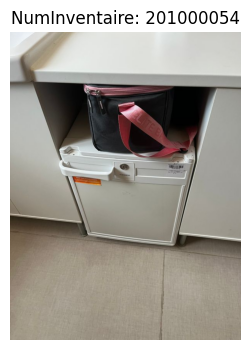

→ Fiche textuelle prédite :
 ARMOIRE DREAM 1 PORTE 1/2 LINGERIE, 1/2 PENDERIE AVEC VALISERIE, PORTE INTERIEUR DIRECT EQUIPEMENT SARL
→ Fiche textuelle correcte :
 REFRIGERATEUR DOMETIC DS 301 H - 28 L DIM H580 X L422 X P393 NEB
--------------------------------------------------------------------------------


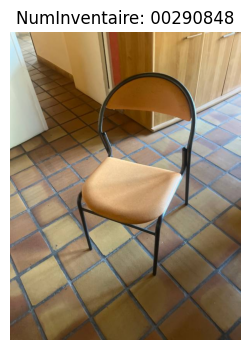

→ Fiche textuelle prédite :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
→ Fiche textuelle correcte :
 CHAISE SERIE 120 - REVETEMENT EXPANSE SUR JERSEY - KUMQUAT OLLIVIER YVES S.A.
--------------------------------------------------------------------------------

✅ Exemples correctement prédits :



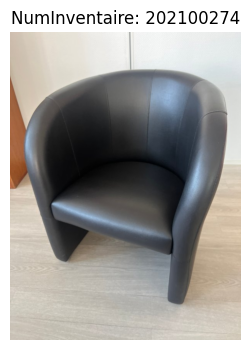

→ Fiche textuelle prédite :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
→ Fiche textuelle correcte :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
--------------------------------------------------------------------------------


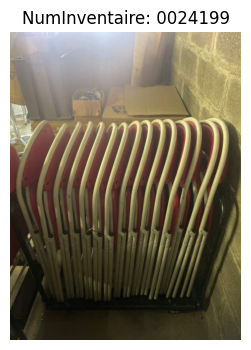

→ Fiche textuelle prédite :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
→ Fiche textuelle correcte :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
--------------------------------------------------------------------------------


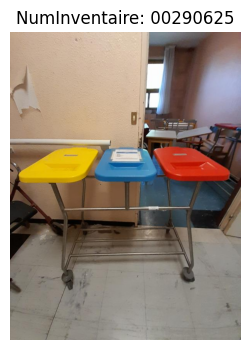

→ Fiche textuelle prédite :
 CHARIOT SUPPORT 3 SACS AVEC COUVERCLES JAUNE-BLEU-ROUGE PS3 ISEO REF 6030 FRANCE HOPITAL
→ Fiche textuelle correcte :
 CHARIOT SUPPORT 3 SACS AVEC COUVERCLES JAUNE-BLEU-ROUGE PS3 ISEO REF 6030 FRANCE HOPITAL
--------------------------------------------------------------------------------


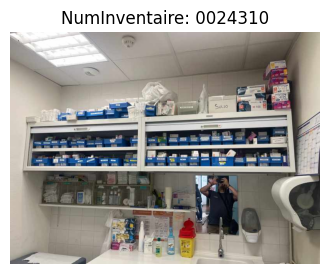

→ Fiche textuelle prédite :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
→ Fiche textuelle correcte :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
--------------------------------------------------------------------------------


In [25]:
import random
import matplotlib.pyplot as plt
import torch

# --- 1️⃣ 5 exemples aléatoires ---
print("🎲 Exemples aléatoires :\n")

sample_indices = random.sample(range(len(df_test_sample)), 5)

for i in sample_indices:
    sims = similarity_matrix[i]
    top1_idx = torch.argmax(sims).item()
    predicted_text = df_test_sample["fiche_textuelle"].iloc[top1_idx]
    true_text = df_test_sample["fiche_textuelle"].iloc[i]

    plt.figure(figsize=(4, 4))
    plt.imshow(df_test_sample["image_obj"].iloc[i])
    plt.axis("off")
    plt.title(f"NumInventaire: {df_test_sample['NumInventaire'].iloc[i]}")
    plt.show()

    print("→ Fiche textuelle prédite :\n", predicted_text)
    print("→ Fiche textuelle correcte :\n", true_text)
    print("-" * 80)


# --- 2️⃣ 5 exemples correctement prédits ---
print("\n✅ Exemples correctement prédits :\n")

good_indices = []
for i in range(len(df_test_sample)):
    sims = similarity_matrix[i]
    top1_idx = torch.argmax(sims).item()
    if top1_idx == i:  # prédiction correcte
        good_indices.append(i)

if len(good_indices) == 0:
    print("Aucun bon résultat trouvé 😅")
else:
    selected = random.sample(good_indices, min(5, len(good_indices)))

    for i in selected:
        sims = similarity_matrix[i]
        top1_idx = torch.argmax(sims).item()
        predicted_text = df_test_sample["fiche_textuelle"].iloc[top1_idx]
        true_text = df_test_sample["fiche_textuelle"].iloc[i]

        plt.figure(figsize=(4, 4))
        plt.imshow(df_test_sample["image_obj"].iloc[i])
        plt.axis("off")
        plt.title(f"NumInventaire: {df_test_sample['NumInventaire'].iloc[i]}")
        plt.show()

        print("→ Fiche textuelle prédite :\n", predicted_text)
        print("→ Fiche textuelle correcte :\n", true_text)
        print("-" * 80)
